<a href="https://colab.research.google.com/github/S18-Niloy/Customer-Retention-Prediction/blob/main/Customer_Retention_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

# data exploration and visualization (EDA)

In [ ]:
data = pd.read_csv("/content/dataset.csv")
print(data.shape)
print(data.head())

(1000, 15)
   Customer_ID  Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
0            1   62  Other          45.15      5892.58                  5   
1            2   65   Male          79.51      9025.47                 13   
2            3   18   Male          29.19       618.83                 13   
3            4   21  Other          79.63      9110.30                  3   
4            5   21  Other          77.66      5390.88                 15   

   Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
0                22                      453.80               2   
1                77                       22.90               2   
2                71                       50.53               5   
3                33                      411.83               5   
4                43                      101.19               3   

   Num_of_Support_Contacts  Satisfaction_Score  Last_Purchase_Days_Ago  \
0                        0                   3   

In [ ]:
target_col = [c for c in data.columns if 'churn' in c.lower() or 'turnover' in c.lower()]
target_col = target_col[0] if target_col else data.columns[-1]
print("\nTarget Column:", target_col)


Target Column: Target_Churn


In [ ]:
print("Missing Values:", data.isnull().sum())
print('-----------------------')
print("\nDuplicate Rows:", data.duplicated().sum())

Missing Values: Customer_ID                   0
Age                           0
Gender                        0
Annual_Income                 0
Total_Spend                   0
Years_as_Customer             0
Num_of_Purchases              0
Average_Transaction_Amount    0
Num_of_Returns                0
Num_of_Support_Contacts       0
Satisfaction_Score            0
Last_Purchase_Days_Ago        0
Email_Opt_In                  0
Promotion_Response            0
Target_Churn                  0
dtype: int64
-----------------------

Duplicate Rows: 0


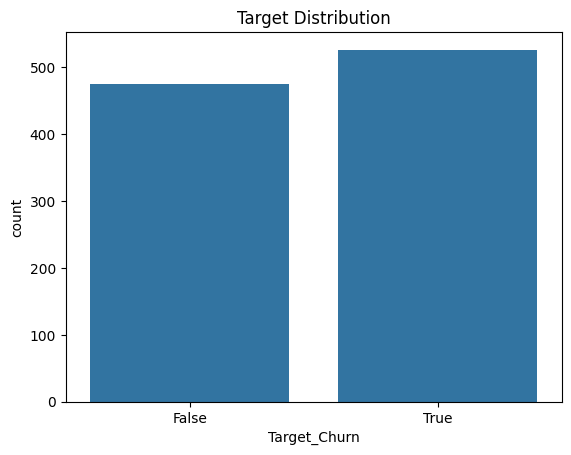

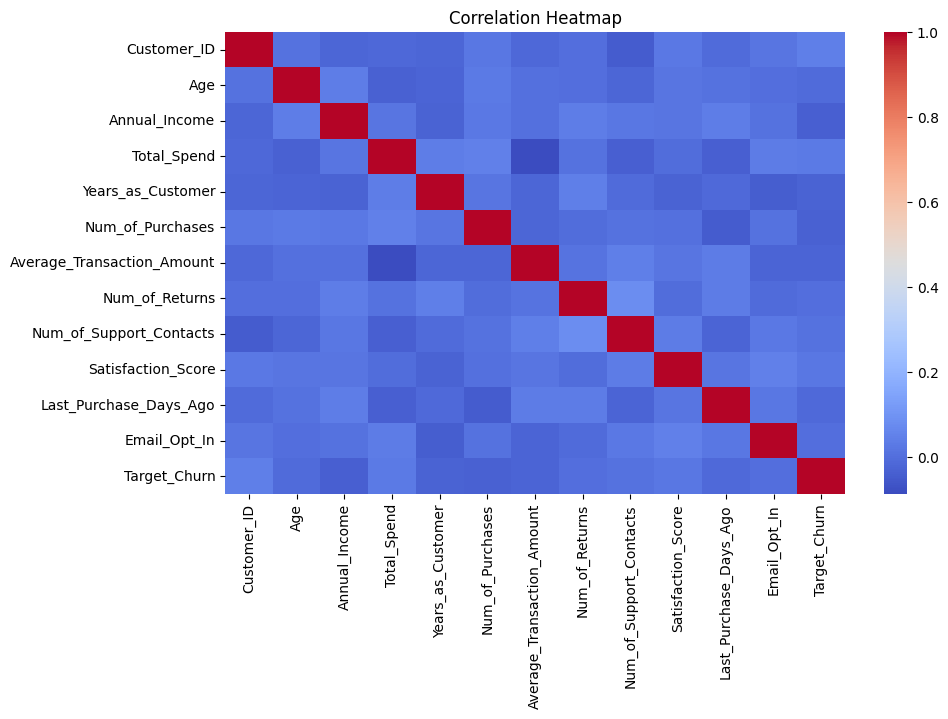

In [ ]:
data = data.drop_duplicates()
data.fillna(method='ffill', inplace=True)

# Plot Target Distribution
sns.countplot(x=target_col, data=data)
plt.title("Target Distribution")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Preprocess and clean data properly

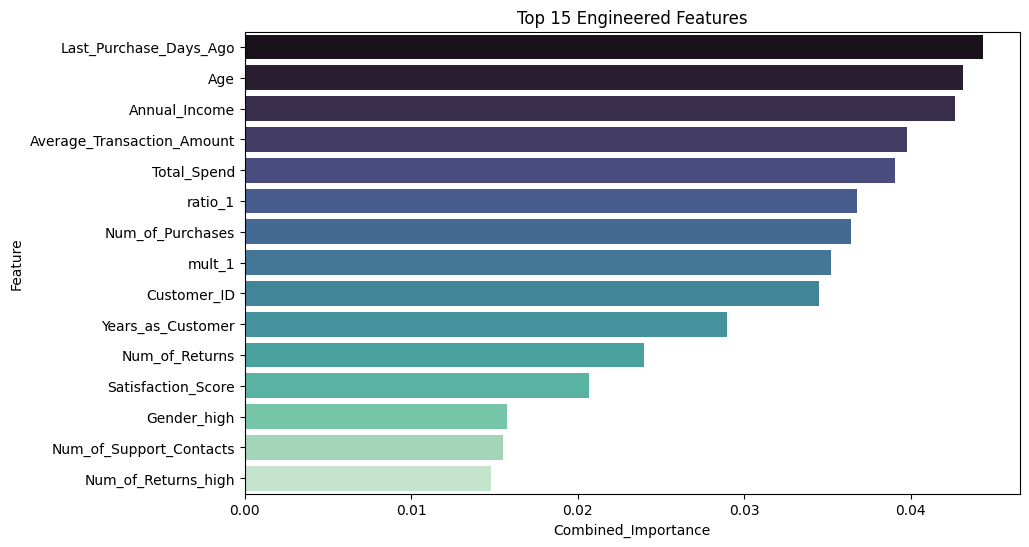


Selected Top 20 Features for Model Training


In [ ]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns
le = LabelEncoder()
for c in cat_cols:
    data[c] = le.fit_transform(data[c].astype(str))

X = data.drop(columns=[target_col])
y = data[target_col]
num_cols = X.select_dtypes(include=[np.number]).columns

# Outlier Capping
def cap_outliers(df, cols, lower=0.01, upper=0.99):
    for c in cols:
        low, high = df[c].quantile([lower, upper])
        df[c] = np.clip(df[c], low, high)
    return df
X = cap_outliers(X, num_cols)

# Ratio / Interaction Features
if len(num_cols) >= 2:
    X["ratio_1"] = X[num_cols[0]] / (X[num_cols[1]] + 1e-5)
    X["sum_1"] = X[num_cols[0]] + X[num_cols[1]]
    X["diff_1"] = X[num_cols[0]] - X[num_cols[1]]
    X["mult_1"] = X[num_cols[0]] * X[num_cols[1]]

# Binary Flag Features
for col in num_cols:
    X[f"{col}_high"] = (X[col] > X[col].median()).astype(int)

# Correlation Reduction
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X.drop(columns=to_drop, inplace=True, errors='ignore')

# Mutual Information & Feature Importance
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_imp = pd.DataFrame({'Feature': X.columns, 'RF_Importance': rf.feature_importances_}).sort_values('RF_Importance', ascending=False)

feat_rank = mi_df.merge(rf_imp, on='Feature', how='outer').fillna(0)
feat_rank['Combined_Importance'] = (feat_rank['MI_Score'] + feat_rank['RF_Importance']) / 2
feat_rank = feat_rank.sort_values(by='Combined_Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_rank.head(15), x='Combined_Importance', y='Feature', palette='mako')
plt.title("Top 15 Engineered Features")
plt.show()

top_features = feat_rank.head(20)['Feature'].tolist()
X = X[top_features]

print(f"\nSelected Top {len(top_features)} Features for Model Training")

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Handle Class Imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

After SMOTE: [368 368]


# Design and train a predictive model (ML and DL)



RandomForest Performance:
Accuracy=0.467 | Precision=0.494 | Recall=0.519 | F1=0.506 | AUC=0.464


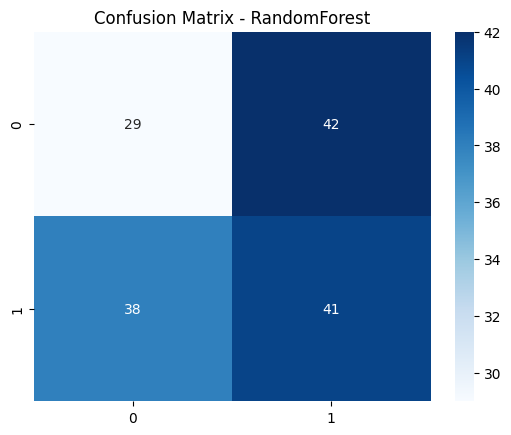

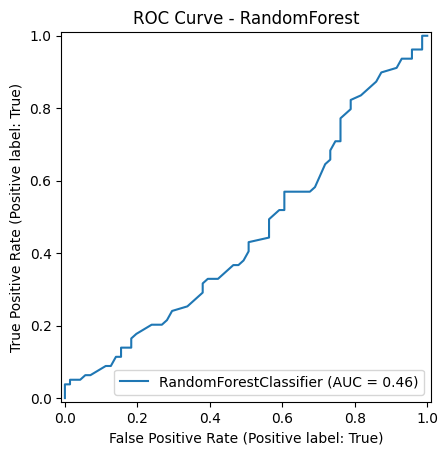


XGBoost Performance:
Accuracy=0.440 | Precision=0.470 | Recall=0.494 | F1=0.481 | AUC=0.437


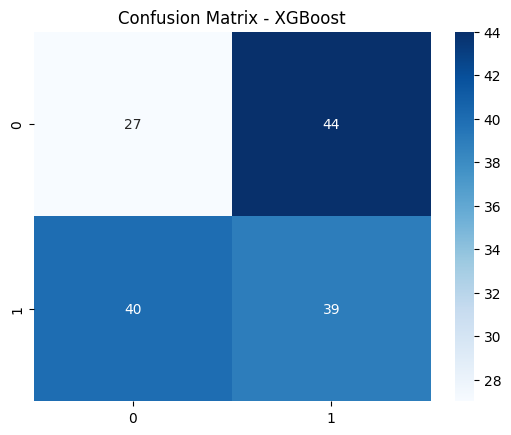

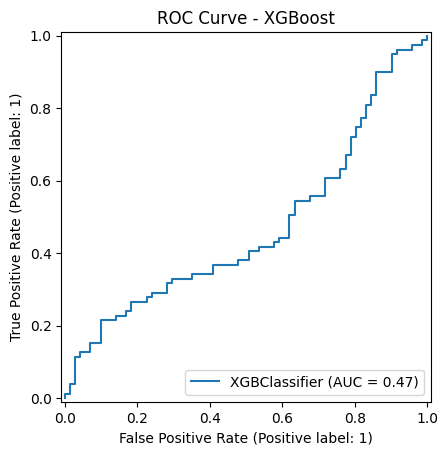

[LightGBM] [Info] Number of positive: 368, number of negative: 368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

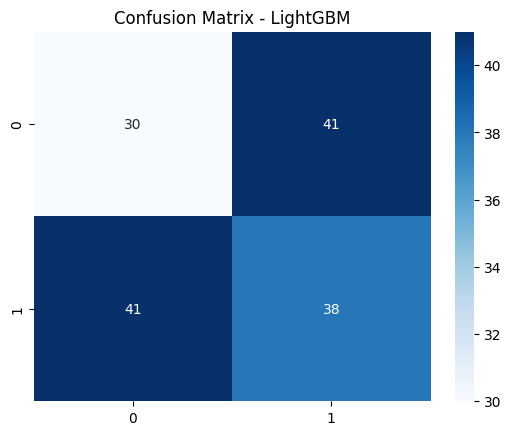

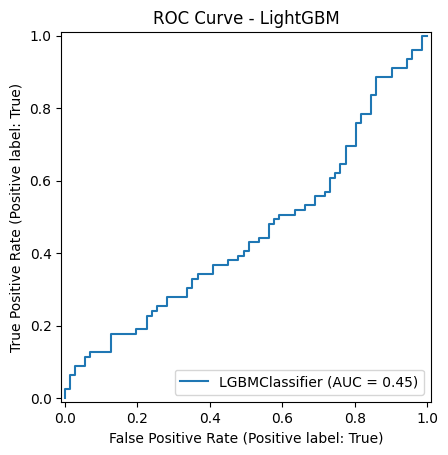

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

ANN Performance: Accuracy=0.493 | Precision=0.521 | Recall=0.468 | F1=0.493 | AUC=0.495


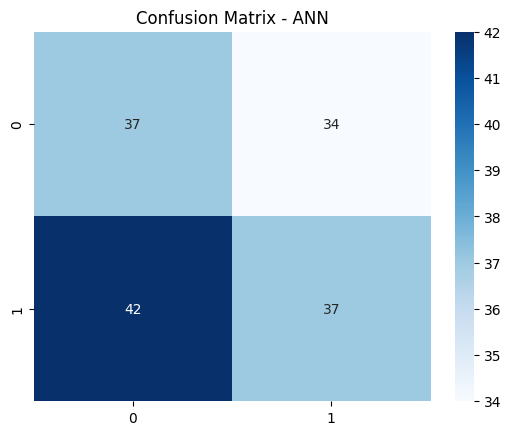

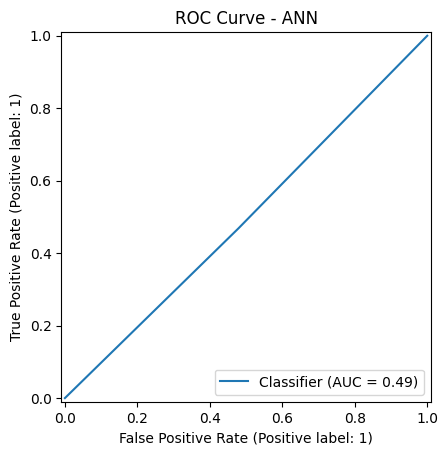

In [ ]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

results = []

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
results.append(evaluate(rf, X_test, y_test, "RandomForest"))

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train_res, y_train_res)
results.append(evaluate(xgb, X_test, y_test, "XGBoost"))

# LightGBM
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train_res, y_train_res)
results.append(evaluate(lgb, X_test, y_test, "LightGBM"))

# ANN
ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train_res, y_train_res, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))

y_pred_ann = (ann.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_ann)
prec = precision_score(y_test, y_pred_ann)
rec = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
auc = roc_auc_score(y_test, y_pred_ann)
print(f"\nANN Performance: Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

cm = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - ANN")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_ann)
plt.title("ROC Curve - ANN")
plt.show()

results.append({"Model": "ANN", "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})

# Evaluate model performance


=== Model Comparison ===
          Model  Accuracy  Precision    Recall        F1       AUC
0  RandomForest  0.466667   0.493976  0.518987  0.506173  0.463719
1       XGBoost  0.440000   0.469880  0.493671  0.481481  0.436976
2      LightGBM  0.453333   0.481013  0.481013  0.481013  0.451774
3           ANN  0.493333   0.521127  0.468354  0.493333  0.494741


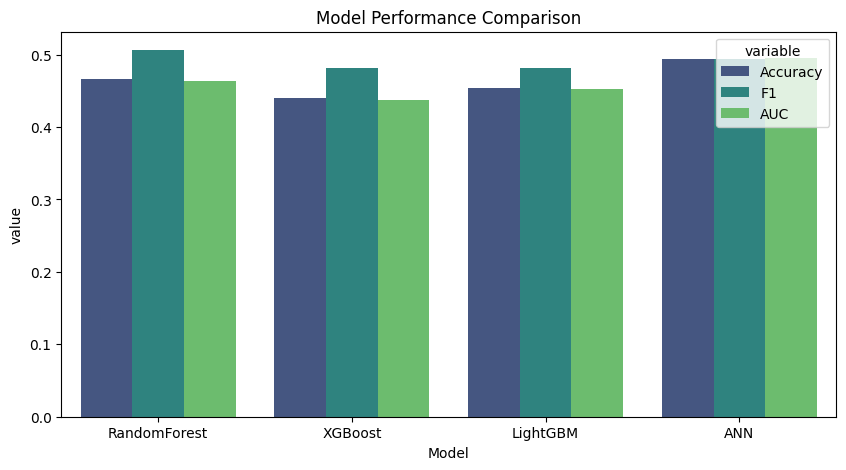

In [ ]:
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

plt.figure(figsize=(10,5))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=['Accuracy','F1','AUC']),
            x='Model', y='value', hue='variable', palette='viridis')
plt.title("Model Performance Comparison")
plt.show()

In [ ]:
best = results_df.loc[results_df['AUC'].idxmax()]
print(f"Best Model: {best['Model']} (AUC={best['AUC']:.3f})")

Best Model: ANN (AUC=0.495)
